# 知识蒸馏

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data


torch.manual_seed(0)
torch.set_num_threads(12)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## 老师网络 

In [2]:
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        output = self.fc2(x)
        return output


def train_teacher(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_teacher(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)


### 老师网络的训练

In [3]:
def teacher_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = TeacherNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    teacher_history = []

    for epoch in range(1, epochs + 1):
        train_teacher(model, device, train_loader, optimizer, epoch)
        loss, acc = test_teacher(model, device, test_loader)
        
        teacher_history.append((loss, acc))

    torch.save(model.state_dict(), "teacher.pt")
    return model, teacher_history

In [4]:
# 训练老师网络

teacher_model, teacher_history = teacher_main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0502, accuracy: 9831/10000 (98%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0412, accuracy: 9864/10000 (99%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0342, accuracy: 9891/10000 (99%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0386, accuracy: 9895/10000 (99%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0306, accuracy: 9899/10000 (99%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0369, accuracy: 9890/10000 (99%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0301, accuracy: 9903/10000 (99%)
Train 

### 老师的暗知识 

In [5]:
import numpy as np
from matplotlib import pyplot as plt

def softmax_t(x, t):
    x_exp = np.exp(x / t)
    return x_exp / np.sum(x_exp)

test_loader_bs1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=1, shuffle=True)

Output (NO softmax): [-25.962477  -28.654276   -1.2635562 -20.311571  -35.82189   -43.393127
 -32.87733   -21.071562  -21.182238  -36.376247 ]


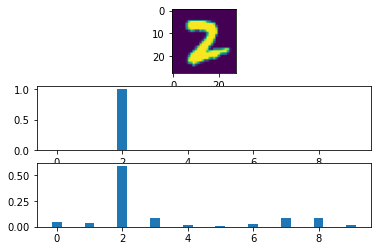

In [6]:
#*****************读取老师模型数据****************#
teacher_model=TeacherNet().to(device)
teacher_model.load_state_dict(torch.load("teacher.pt"))
#*****************读取老师模型数据****************#

teacher_model.eval()
with torch.no_grad():
    data, target = next(iter(test_loader_bs1))
#    data, target = data.to('cuda'), target.to('cuda')
    output = teacher_model(data)

test_x = data.cpu().numpy()
y_out = output.cpu().numpy()
y_out = y_out[0, ::]
print('Output (NO softmax):', y_out)

plt.subplot(3, 1, 1)
plt.imshow(test_x[0, 0, ::])

plt.subplot(3, 1, 2)
plt.bar(list(range(10)), softmax_t(y_out, 1), width=0.3)

plt.subplot(3, 1, 3)
plt.bar(list(range(10)), softmax_t(y_out, 10), width=0.3)
plt.show()

## 学生网络 

In [7]:
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = F.relu(self.fc3(x))
        return output

### 学生网络自训练

In [8]:
## 让学生自己学，不使用KD
def train_student(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [9]:
def student_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = StudentNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    student_history = []
    
    for epoch in range(1, epochs + 1):
        train_student(model, device, train_loader, optimizer, epoch)
        loss, acc = test_student(model, device, test_loader)
        student_history.append((loss, acc))

    torch.save(model.state_dict(), "student.pt")
    return model, student_history

In [10]:
student_simple_model, student_simple_history = student_main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.3526, accuracy: 8685/10000 (87%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.3703, accuracy: 8597/10000 (86%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.3212, accuracy: 8781/10000 (88%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.3094, accuracy: 8820/10000 (88%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.3113, accuracy: 8820/10000 (88%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.3265, accuracy: 8794/10000 (88%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.3176, accuracy: 8819/10000 (88%)
Train 

### 学生网络利用知识蒸馏训练 

In [11]:
# 定义学生网络蒸馏的loss 
def distillation(y, labels, teacher_scores, temp, alpha):
    return nn.KLDivLoss()(F.log_softmax(y / temp, dim=1), F.softmax(teacher_scores / temp, dim=1)) * (
            temp * temp * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)


In [12]:
def train_student_kd(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        teacher_output = teacher_model(data)
        teacher_output = teacher_output.detach()  # 切断老师网络的反向传播
        loss = distillation(output, target, teacher_output, temp=5.0, alpha=0.9)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student_kd(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [13]:
def student_kd_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = StudentNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    student_history = []
    for epoch in range(1, epochs + 1):
        train_student_kd(model, device, train_loader, optimizer, epoch)
        loss, acc = test_student_kd(model, device, test_loader)
        student_history.append((loss, acc))

    torch.save(model.state_dict(), "student_kd.pt")
    return model, student_history

In [14]:
student_kd_model, student_kd_history = student_kd_main()

Train epoch 1: 384/60000, [->                                                 ] 2%

/home/wxq/machine_learning/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1957, accuracy: 9625/10000 (96%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1365, accuracy: 9706/10000 (97%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0890, accuracy: 9798/10000 (98%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0894, accuracy: 9806/10000 (98%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0857, accuracy: 9798/10000 (98%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0766, accuracy: 9826/10000 (98%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0834, accuracy: 9814/10000 (98%)
Train 

## 绘图

In [15]:
import matplotlib.pyplot as plt

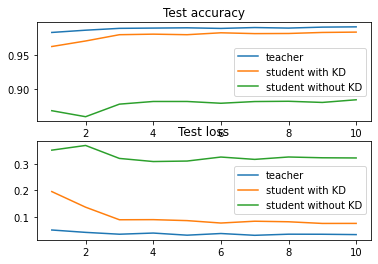

In [16]:
epochs = 10
x = list(range(1, epochs+1))

plt.subplot(2, 1, 1)
plt.plot(x, [teacher_history[i][1] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][1] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][1] for i in range(epochs)], label='student without KD')

plt.title('Test accuracy')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(x, [teacher_history[i][0] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][0] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][0] for i in range(epochs)], label='student without KD')

plt.title('Test loss')
plt.legend()


